# Credits
> This code is a slight modification to a translation (TensorFlow --> PyTorch) of a previous version of the [02456](http://kurser.dtu.dk/course/02456) course material. 
> [Original repo link (TensorFlow)](https://github.com/DeepLearningDTU/02456-deep-learning).
> [Translated repo link (PyTorch)](https://github.com/munkai/pytorch-tutorial/tree/master/2_intermediate).

In [74]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from torch.nn.parameter import Parameter
from torchvision.datasets import MNIST

# MNIST dataset
MNIST is a dataset that is often used for benchmarking. The MNIST dataset consists of 70,000 images of handwritten digits from 0-9. The dataset is split into a 50,000 images training set, 10,000 images validation set and 10,000 images test set. The images are 28x28 pixels, where each pixel represents a normalised value between 0-255 (0=black and 255=white).

![MNIST.Exampel](../static_files/mnist.png)


## Primer
We use a feedforward neural network to classify the 28x28 mnist images. `num_features` is therefore $28 * 28=784$, i.e. we represent each image as a vector. The ordering of the pixels in the vector does not matter, so we could permutate all images using the same permutation and still get the same performance. (You are of course encouraged to try this using ``numpy.random.permutation`` to get a random permutation. This task is therefore called the _permutation invariant_ MNIST. Obviously this throws away a lot of structure in the data. In the next module we'll fix this with the convolutional neural network wich encodes prior knowledgde about data that has either spatial or temporal structure.  

## MNIST
First let's load the MNIST dataset and plot a few examples:

In [75]:
mnist_trainset = MNIST("./temp/", train=True, download=True)
mnist_testset = MNIST("./temp/", train=False, download=True)

In [76]:
# To speed up training we'll only work on a subset of the data
x_train = mnist_trainset.data[:1000].view(-1, 784).float()
targets_train = mnist_trainset.targets[:1000]

x_valid = mnist_trainset.data[1000:1500].view(-1, 784).float()
targets_valid = mnist_trainset.targets[1000:1500]

x_test = mnist_testset.data[:500].view(-1, 784).float()
targets_test = mnist_testset.targets[:500]

print("Information on dataset")
print("x_train", x_train.shape)
print("targets_train", targets_train.shape)
print("x_valid", x_valid.shape)
print("targets_valid", targets_valid.shape)
print("x_test", x_test.shape)
print("targets_test", targets_test.shape)

Information on dataset
x_train torch.Size([1000, 784])
targets_train torch.Size([1000])
x_valid torch.Size([500, 784])
targets_valid torch.Size([500])
x_test torch.Size([500, 784])
targets_test torch.Size([500])


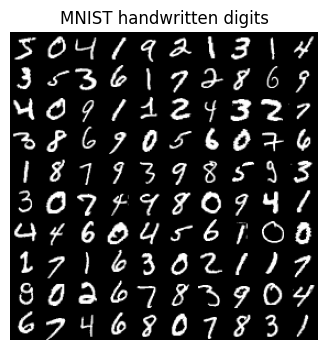

In [77]:
# plot a few MNIST examples
idx, dim, classes = 0, 28, 10
# create empty canvas
canvas = np.zeros((dim*classes, classes*dim))

# fill with tensors
for i in range(classes):
    for j in range(classes):
        canvas[i*dim:(i+1)*dim, j*dim:(j+1)*dim] = x_train[idx].reshape((dim, dim))
        idx += 1

# visualize matrix of tensors as gray scale image
plt.figure(figsize=(4, 4))
plt.axis('off')
plt.imshow(canvas, cmap='gray')
plt.title('MNIST handwritten digits')
plt.show()

## Model

One of the large challenges in deep learning is the amount of hyperparameters that needs to be selected, and the lack of a good principled way of selecting them.
Hyperparameters can be found by experience (guessing) or some search procedure (often quite slow).
Random search is easy to implement and performs decent: http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf . 
More advanced search procedures include [Spearmint](https://github.com/JasperSnoek/spearmint) and many others.

**In practice a lot of trial and error is almost always involved.** This can be frustrating and time consuming, but the best thing to do is to think as a scientist, and go about it in a ordered manner --> monitor as much as you can, take notes, and be deliberate!

Below are some guidelines that you can use as a starting point to some of the most important hyperparameters. 
(*regularization* is also very important, but will be covered later.)


### Ballpark estimates of hyperparameters
__Number of hidden units and network structure:__
You'll have to experiment. One rarely goes below 512 units for feedforward networks (unless your are training on CPU...).
There's some research into stochastic depth networks: https://arxiv.org/pdf/1603.09382v2.pdf, but in general this is trial and error.

__Parameter initialization:__
Parameter initialization is extremely important.
PyTorch has a lot of different initializers, check the [PyTorch API](http://pytorch.org/docs/master/nn.html#torch-nn-init). Often used initializer are
1. Kaiming He
2. Xavier Glorot
3. Uniform or Normal with small scale (0.1 - 0.01)
4. Orthogonal (this usually works very well for RNNs)

Bias is nearly always initialized to zero using the [torch.nn.init.constant(tensor, val)](http://pytorch.org/docs/master/nn.html#torch.nn.init.constant)

__Mini-batch size:__
Usually people use 16-256. Bigger is not allways better. With smaller mini-batch size you get more updates and your model might converge faster. Also small batch sizes use less memory, which means you can train a model with more parameters.

__Nonlinearity:__ [The most commonly used nonliearities are](http://pytorch.org/docs/master/nn.html#non-linear-activations)
1. ReLU
2. Leaky ReLU
3. ELU
3. Sigmoid (rarely, if ever, used in hidden layers anymore, squashes the output to the interval [0, 1] - appropriate if the targets are binary.
4. Tanh is similar to the sigmoid, but squashes to [-1, 1]. Rarely used any more.
4. Softmax normalizes the output to 1, usrful if you have a multi-class classification problem.

See the plot below.

__Optimizer and learning rate:__
1. SGD + Momentum: learning rate 0.01 - 0.1 
2. ADAM: learning rate 3e-4 - 1e-5
3. RMSPROP: somewhere between SGD and ADAM


softmax should sum to one (approxiamtely): 1.0


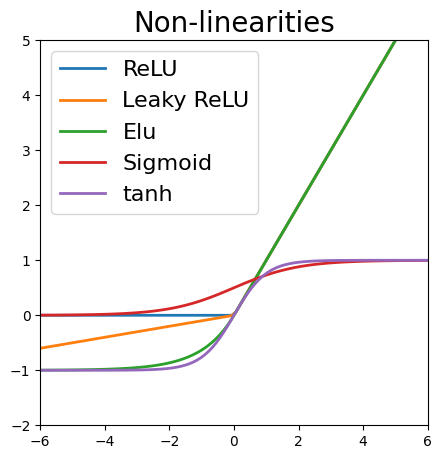

In [78]:
# Illustrate different output units
x = np.linspace(-6, 6, 100)
units = {
    "ReLU": lambda x: np.maximum(0, x),
    "Leaky ReLU": lambda x: np.maximum(0, x) + 0.1 * np.minimum(0, x),
    "Elu": lambda x: (x > 0) * x + (1 - (x > 0)) * (np.exp(x) - 1),
    "Sigmoid": lambda x: (1 + np.exp(-x))**(-1),
    "tanh": lambda x: (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
}

plt.figure(figsize=(5, 5))
[plt.plot(x, unit(x), label=unit_name, lw=2) for unit_name, unit in units.items()]
plt.legend(loc=2, fontsize=16)
plt.title('Non-linearities', fontsize=20)
plt.ylim([-2, 5])
plt.xlim([-6, 6])

# assert that all class probablities sum to one
softmax = lambda x: np.exp(x) / np.sum(np.exp(x))
print("softmax should sum to one (approxiamtely):", np.sum(softmax(x)))

In [79]:
#Hyperparameters
num_classes = 10
num_l1 = 512
num_features = x_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden, num_output):
        super(Net, self).__init__()  
        # input layer
        self.W_1 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden, num_features)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden), 0))
        # hidden layer
        self.W_2 = Parameter(init.xavier_normal_(torch.Tensor(num_output, num_hidden)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_output), 0))
        # define activation function in constructor
        self.activation = torch.nn.ELU()

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        x = F.linear(x, self.W_2, self.b_2)
        x = F.softmax(x, dim=1)
        return x


net = Net(num_features, num_l1, num_classes)

In [80]:
optimizer = optim.SGD(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [81]:
# Test the forward pass with dummy data
x = np.random.normal(0, 1, (45, dim*dim)).astype('float32')

print(net(torch.from_numpy(x)).size())

torch.Size([45, 10])


# Build the training loop

We train the network by calculating the gradient w.r.t the cost function and update the parameters in direction of the negative gradient. 


When training neural network you always use mini batches. Instead of calculating the average gradient using the entire dataset you approximate the gradient using a mini-batch of typically 16 to 256 samples. The paramters are updated after each mini batch. Networks converge much faster using mini batches because the parameters are updated more often.

We build a loop that iterates over the training data. Remember that the parameters are updated each time ``optimizer.step()`` is called.

Epoch  1 : Train Loss 0.230708 , Train acc 0.058000, Valid acc 0.046000
Epoch 11 : Train Loss 0.227520 , Train acc 0.287000, Valid acc 0.226000
Epoch 21 : Train Loss 0.221048 , Train acc 0.366000, Valid acc 0.346000
Epoch 31 : Train Loss 0.214172 , Train acc 0.423000, Valid acc 0.386000
Epoch 41 : Train Loss 0.208605 , Train acc 0.495000, Valid acc 0.454000
Epoch 51 : Train Loss 0.202675 , Train acc 0.624000, Valid acc 0.564000
Epoch 61 : Train Loss 0.196002 , Train acc 0.713000, Valid acc 0.672000
Epoch 71 : Train Loss 0.190282 , Train acc 0.739000, Valid acc 0.714000
Epoch 81 : Train Loss 0.186089 , Train acc 0.745000, Valid acc 0.728000
Epoch 91 : Train Loss 0.183008 , Train acc 0.756000, Valid acc 0.734000
Epoch 101 : Train Loss 0.180669 , Train acc 0.763000, Valid acc 0.742000
Epoch 111 : Train Loss 0.178824 , Train acc 0.770000, Valid acc 0.738000
Epoch 121 : Train Loss 0.177317 , Train acc 0.773000, Valid acc 0.748000
Epoch 131 : Train Loss 0.176042 , Train acc 0.780000, Valid a

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

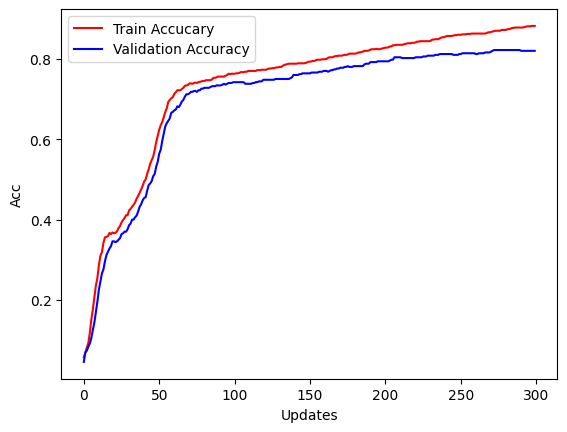

In [82]:
# we could have done this ourselves,
# but we should be aware of sklearn and its tools
from sklearn.metrics import accuracy_score

# normalize the inputs
x_train.div_(255)
x_valid.div_(255)
x_test.div_(255)

# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 300
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(x_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(targets_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

# Assignments

Try and add these modifications (might require some Googleing -- an important skill in deep learning):
- Kaiming He initialization instead of Xavier Glorot
- add an extra layer
- use the relu activation function
- add momentum to the optimizer
- use the ADAM optimizer instead of stochastic gradient descent

### Advanced - Regularization

Regularization is VERY important in practice and is used practically every time.
Many important results are completely dependent on clever use of regularization, and it is something you need to become familiar with if you want to work with deep learning.

- add L1 or L2 weight regularization (aka. weight decay) 
- add dropout to the network (**note** the `net.train()` and `net.eval()` are already in the code)
- add batchnorm

__Pointers on regularization hyperparameter:__
1. L2 and [L1 regularization](http://pytorch.org/docs/master/nn.html#torch.nn.L1Loss) (weight decay of optimization functions) 
  - Normal ranges: 1e-4  -  1e-8
1. [Dropout](http://pytorch.org/docs/master/nn.html?highlight=dropout#torch.nn.Dropout). Dropout rate 0.1-0.5
  - Remember to pick the correct version according to the input dimensionality
  - **NOTE** call `net.train()` before training to activate random dropout, and call `net.eval()` to deactivate dropout while validating or running inference with model.
1. [Batchnorm](http://pytorch.org/docs/master/nn.html#torch.nn.BatchNorm1d): Batchnorm also acts as a regularizer - Often very useful (faster and better convergence)
  - Remember to pick the correct version according to the input dimensionality
  - **NOTE** call `net.train()` before training to activate, and call `net.eval()` to have a non-stochastic variant while validating or running inference with model.
    

### Assignments

I start by redifining the network with Kaiming He Initiliazation

In [83]:
#Hyperparameters
num_classes = 10
num_l1 = 512
num_features = x_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden, num_output):
        super(Net, self).__init__()  
        # input layer
        self.W_1 = Parameter(init.kaiming_normal_(torch.Tensor(num_hidden, num_features)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden), 0))
        # hidden layer
        self.W_2 = Parameter(init.kaiming_normal_(torch.Tensor(num_output, num_hidden)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_output), 0))
        # define activation function in constructor
        self.activation = torch.nn.ELU()

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        x = F.linear(x, self.W_2, self.b_2)
        x = F.softmax(x, dim=1)
        return x


net = Net(num_features, num_l1, num_classes)

optimizer = optim.SGD(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()



Epoch  1 : Train Loss 0.230233 , Train acc 0.120000, Valid acc 0.124000
Epoch 11 : Train Loss 0.225271 , Train acc 0.314000, Valid acc 0.294000
Epoch 21 : Train Loss 0.217028 , Train acc 0.452000, Valid acc 0.426000
Epoch 31 : Train Loss 0.208156 , Train acc 0.586000, Valid acc 0.584000
Epoch 41 : Train Loss 0.200312 , Train acc 0.611000, Valid acc 0.608000
Epoch 51 : Train Loss 0.195327 , Train acc 0.622000, Valid acc 0.624000
Epoch 61 : Train Loss 0.192192 , Train acc 0.629000, Valid acc 0.630000
Epoch 71 : Train Loss 0.190070 , Train acc 0.636000, Valid acc 0.628000
Epoch 81 : Train Loss 0.188534 , Train acc 0.640000, Valid acc 0.634000
Epoch 91 : Train Loss 0.187360 , Train acc 0.644000, Valid acc 0.638000
Epoch 101 : Train Loss 0.186422 , Train acc 0.647000, Valid acc 0.636000
Epoch 111 : Train Loss 0.185644 , Train acc 0.648000, Valid acc 0.638000
Epoch 121 : Train Loss 0.184981 , Train acc 0.649000, Valid acc 0.642000
Epoch 131 : Train Loss 0.184400 , Train acc 0.654000, Valid a

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

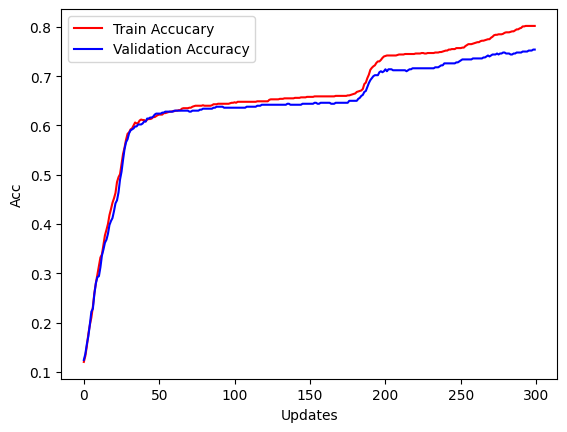

In [84]:
# we could have done this ourselves,
# but we should be aware of sklearn and its tools
from sklearn.metrics import accuracy_score


# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 300
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(x_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(targets_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

Comparing Kamining He initialization to Xavier Glorot it seems like the difference is slightly worse as the achieved validation accuracy is 0.788 for 300 epochs compared to the xavier of 0.812. However this might be random. 

I return to the original network except I add an extra layer

In [85]:
#Hyperparameters
num_classes = 10
num_l1 = 512
num_l2 = 512
num_features = x_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden1,num_hidden2, num_output):
        super(Net, self).__init__()  
        # input layer
        self.W_1 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden1, num_features)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden1), 0))
        # hidden layer
        self.W_2 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden2, num_hidden1)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_hidden2), 0))

        # Another hidden layer
        self.W_3 = Parameter(init.xavier_normal_(torch.Tensor(num_output, num_hidden2)))
        self.b_3 = Parameter(init.constant_(torch.Tensor(num_output), 0))


        # define activation function in constructor
        self.activation = torch.nn.ELU()

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        x = F.linear(x, self.W_2, self.b_2)
        x = self.activation(x) # added another activation function
        x = F.linear(x, self.W_3, self.b_3) # added another layer
        
        x = F.softmax(x, dim=1)
        return x


net = Net(num_features, num_l1,num_l2, num_classes)

optimizer = optim.SGD(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()



Epoch  1 : Train Loss 0.229487 , Train acc 0.140000, Valid acc 0.118000
Epoch 11 : Train Loss 0.224296 , Train acc 0.379000, Valid acc 0.322000
Epoch 21 : Train Loss 0.214023 , Train acc 0.532000, Valid acc 0.484000
Epoch 31 : Train Loss 0.203252 , Train acc 0.554000, Valid acc 0.516000
Epoch 41 : Train Loss 0.195808 , Train acc 0.636000, Valid acc 0.590000
Epoch 51 : Train Loss 0.189221 , Train acc 0.739000, Valid acc 0.706000
Epoch 61 : Train Loss 0.183976 , Train acc 0.756000, Valid acc 0.734000
Epoch 71 : Train Loss 0.180240 , Train acc 0.767000, Valid acc 0.734000
Epoch 81 : Train Loss 0.177511 , Train acc 0.774000, Valid acc 0.734000
Epoch 91 : Train Loss 0.175411 , Train acc 0.786000, Valid acc 0.744000
Epoch 101 : Train Loss 0.173681 , Train acc 0.794000, Valid acc 0.752000
Epoch 111 : Train Loss 0.172083 , Train acc 0.808000, Valid acc 0.762000
Epoch 121 : Train Loss 0.170270 , Train acc 0.839000, Valid acc 0.772000
Epoch 131 : Train Loss 0.168380 , Train acc 0.865000, Valid a

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

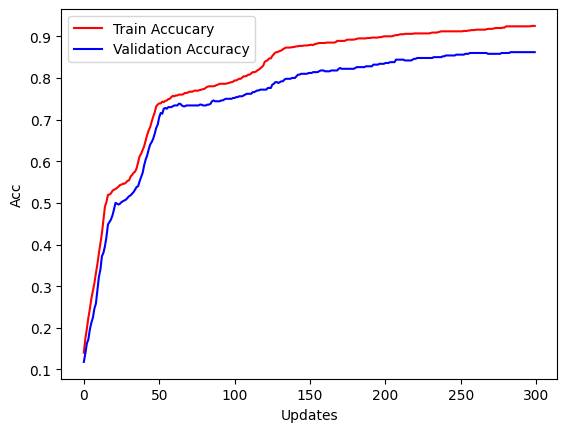

In [86]:
# we could have done this ourselves,
# but we should be aware of sklearn and its tools
from sklearn.metrics import accuracy_score


# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 300
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(x_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(targets_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

Adding an extra layer to the original network compared to the original with xavier initialization it seems slightly better with a accuracy of 0.826 compared to 0.812 and the accuracy curve does still seem increasing. 

Then I try the original network but with Relu activation function instead:

In [87]:
#Hyperparameters
num_classes = 10
num_l1 = 512
num_features = x_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden, num_output):
        super(Net, self).__init__()  
        # input layer
        self.W_1 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden, num_features)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden), 0))
        # hidden layer
        self.W_2 = Parameter(init.xavier_normal_(torch.Tensor(num_output, num_hidden)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_output), 0))
        # define activation function in constructor
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        x = F.linear(x, self.W_2, self.b_2)
        x = F.softmax(x, dim=1)
        return x


net = Net(num_features, num_l1, num_classes)

optimizer = optim.SGD(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

Epoch  1 : Train Loss 0.229932 , Train acc 0.151000, Valid acc 0.154000
Epoch 11 : Train Loss 0.227971 , Train acc 0.269000, Valid acc 0.220000
Epoch 21 : Train Loss 0.225104 , Train acc 0.328000, Valid acc 0.320000
Epoch 31 : Train Loss 0.221045 , Train acc 0.386000, Valid acc 0.358000
Epoch 41 : Train Loss 0.216067 , Train acc 0.483000, Valid acc 0.454000
Epoch 51 : Train Loss 0.209883 , Train acc 0.568000, Valid acc 0.554000
Epoch 61 : Train Loss 0.203760 , Train acc 0.613000, Valid acc 0.586000
Epoch 71 : Train Loss 0.198573 , Train acc 0.626000, Valid acc 0.598000
Epoch 81 : Train Loss 0.194799 , Train acc 0.634000, Valid acc 0.606000
Epoch 91 : Train Loss 0.192075 , Train acc 0.643000, Valid acc 0.612000
Epoch 101 : Train Loss 0.190031 , Train acc 0.647000, Valid acc 0.616000
Epoch 111 : Train Loss 0.188423 , Train acc 0.652000, Valid acc 0.616000
Epoch 121 : Train Loss 0.187096 , Train acc 0.653000, Valid acc 0.616000
Epoch 131 : Train Loss 0.185932 , Train acc 0.660000, Valid a

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

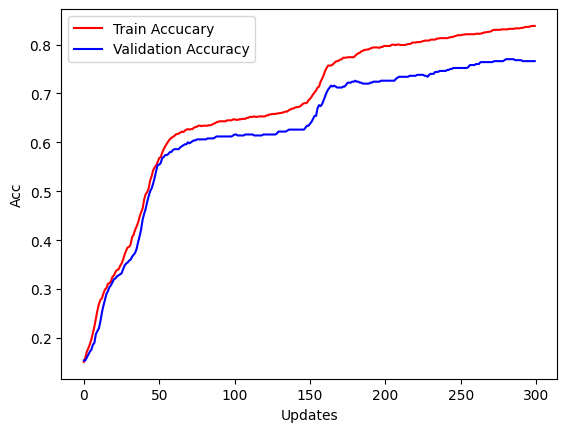

In [88]:
# we could have done this ourselves,
# but we should be aware of sklearn and its tools
from sklearn.metrics import accuracy_score


# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 300
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(x_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(targets_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

Compared to the original network with Elu activation the network with ReLU seems slightly better converging and achives a slightly better accuracy of 0.816 compared to 0.812

Then I try the original network but with momentum to the optimizer SDG

In [89]:
#Hyperparameters
num_classes = 10
num_l1 = 512
num_features = x_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden, num_output):
        super(Net, self).__init__()  
        # input layer
        self.W_1 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden, num_features)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden), 0))
        # hidden layer
        self.W_2 = Parameter(init.xavier_normal_(torch.Tensor(num_output, num_hidden)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_output), 0))
        # define activation function in constructor
        self.activation = torch.nn.ELU()

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        x = F.linear(x, self.W_2, self.b_2)
        x = F.softmax(x, dim=1)
        return x


net = Net(num_features, num_l1, num_classes)

optimizer = optim.SGD(net.parameters(), lr=0.01,momentum=0.9)
criterion = nn.CrossEntropyLoss()

Epoch  1 : Train Loss 0.230087 , Train acc 0.181000, Valid acc 0.180000
Epoch 11 : Train Loss 0.183129 , Train acc 0.762000, Valid acc 0.740000
Epoch 21 : Train Loss 0.170352 , Train acc 0.838000, Valid acc 0.776000
Epoch 31 : Train Loss 0.163784 , Train acc 0.894000, Valid acc 0.820000
Epoch 41 : Train Loss 0.160383 , Train acc 0.907000, Valid acc 0.838000
Epoch 51 : Train Loss 0.158307 , Train acc 0.916000, Valid acc 0.842000
Epoch 61 : Train Loss 0.156881 , Train acc 0.929000, Valid acc 0.844000
Epoch 71 : Train Loss 0.155793 , Train acc 0.941000, Valid acc 0.846000
Epoch 81 : Train Loss 0.154919 , Train acc 0.947000, Valid acc 0.846000
Epoch 91 : Train Loss 0.154203 , Train acc 0.949000, Valid acc 0.844000
Epoch 101 : Train Loss 0.153609 , Train acc 0.952000, Valid acc 0.842000
Epoch 111 : Train Loss 0.153108 , Train acc 0.953000, Valid acc 0.842000
Epoch 121 : Train Loss 0.152680 , Train acc 0.956000, Valid acc 0.840000
Epoch 131 : Train Loss 0.152314 , Train acc 0.957000, Valid a

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

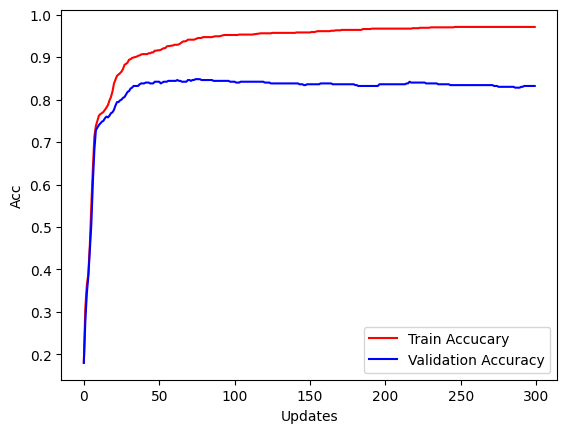

In [90]:
# we could have done this ourselves,
# but we should be aware of sklearn and its tools
from sklearn.metrics import accuracy_score


# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 300
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(x_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(targets_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

Adding momentum to the original network really seems to help it converge faster as it achieved a higher accuracy around 0.84. However it also seems that the learning curve have saturated. Thus I conclude it helps speeding the learning rate up but that it might not affect the maximum achievable accuracy. 

Last for the regular assignment steps I try to use Adam optimizer for the original network instead of SGD 

Adam use beta values instead of momentum. Here I just use the standard betas = (0.9, 0.999)

In [103]:
#Hyperparameters
num_classes = 10
num_l1 = 512
num_features = x_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden, num_output):
        super(Net, self).__init__()  
        # input layer
        self.W_1 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden, num_features)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden), 0))
        # hidden layer
        self.W_2 = Parameter(init.xavier_normal_(torch.Tensor(num_output, num_hidden)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_output), 0))
        # define activation function in constructor
        self.activation = torch.nn.ELU()

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        x = F.linear(x, self.W_2, self.b_2)
        x = F.softmax(x, dim=1)
        return x


net = Net(num_features, num_l1, num_classes)

optimizer = optim.Adam(net.parameters(), lr = 1e-4,betas = (0.9, 0.999))
criterion = nn.CrossEntropyLoss()

Epoch  1 : Train Loss 0.228743 , Train acc 0.283000, Valid acc 0.278000
Epoch 11 : Train Loss 0.178884 , Train acc 0.777000, Valid acc 0.736000
Epoch 21 : Train Loss 0.167129 , Train acc 0.860000, Valid acc 0.816000
Epoch 31 : Train Loss 0.161245 , Train acc 0.908000, Valid acc 0.828000
Epoch 41 : Train Loss 0.157334 , Train acc 0.933000, Valid acc 0.844000
Epoch 51 : Train Loss 0.155065 , Train acc 0.948000, Valid acc 0.852000
Epoch 61 : Train Loss 0.153519 , Train acc 0.959000, Valid acc 0.852000
Epoch 71 : Train Loss 0.152347 , Train acc 0.967000, Valid acc 0.850000
Epoch 81 : Train Loss 0.151463 , Train acc 0.971000, Valid acc 0.850000
Epoch 91 : Train Loss 0.150802 , Train acc 0.974000, Valid acc 0.852000
Epoch 101 : Train Loss 0.150256 , Train acc 0.977000, Valid acc 0.852000
Epoch 111 : Train Loss 0.149722 , Train acc 0.980000, Valid acc 0.848000
Epoch 121 : Train Loss 0.149308 , Train acc 0.981000, Valid acc 0.848000
Epoch 131 : Train Loss 0.149058 , Train acc 0.981000, Valid a

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

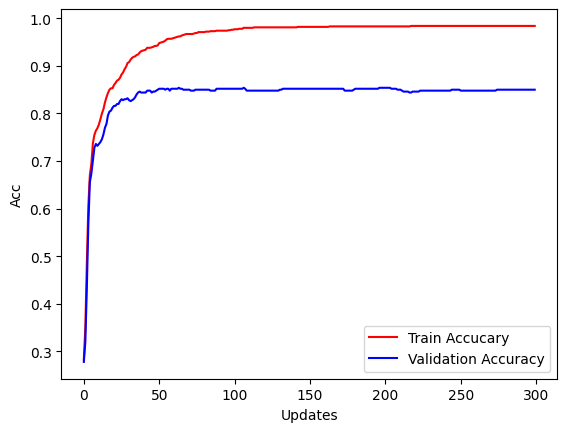

In [104]:


# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 300
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(x_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(targets_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

This achieves the highest accuracy yet compared to the original model of the tried additions with an accuracy of 0.872. I note also that the learning curve seems quickly saturated indicating that the Adam optimizer ensure fast convergence for this problem but that the potential for this version of the network have been reached. 

$\textbf{To get further accuracy I might want to combine some of the additional features such as an extra layer, relu and Adam optimizer.} $

Thus I try to combine Relu, extra layer and Adam optimizer:

In [107]:
#Hyperparameters
num_classes = 10
num_l1 = 512
num_l2 = 512
num_features = x_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden1,num_hidden2, num_output):
        super(Net, self).__init__()  
        # input layer
        self.W_1 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden1, num_features)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden1), 0))
        # hidden layer
        self.W_2 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden2, num_hidden1)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_hidden2), 0))

        # Another hidden layer
        self.W_3 = Parameter(init.xavier_normal_(torch.Tensor(num_output, num_hidden2)))
        self.b_3 = Parameter(init.constant_(torch.Tensor(num_output), 0))


        # define activation function in constructor
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        x = F.linear(x, self.W_2, self.b_2)
        x = self.activation(x) # added another activation function
        x = F.linear(x, self.W_3, self.b_3) # added another layer
        
        x = F.softmax(x, dim=1)
        return x


net = Net(num_features, num_l1,num_l2, num_classes)

optimizer = optim.Adam(net.parameters(), lr=1e-5,betas = (0.9, 0.999))
criterion = nn.CrossEntropyLoss()



Epoch  1 : Train Loss 0.230148 , Train acc 0.134000, Valid acc 0.154000
Epoch 11 : Train Loss 0.226347 , Train acc 0.477000, Valid acc 0.428000
Epoch 21 : Train Loss 0.218168 , Train acc 0.555000, Valid acc 0.524000
Epoch 31 : Train Loss 0.206200 , Train acc 0.591000, Valid acc 0.540000
Epoch 41 : Train Loss 0.195881 , Train acc 0.656000, Valid acc 0.604000
Epoch 51 : Train Loss 0.187422 , Train acc 0.717000, Valid acc 0.686000
Epoch 61 : Train Loss 0.181841 , Train acc 0.730000, Valid acc 0.702000
Epoch 71 : Train Loss 0.177015 , Train acc 0.796000, Valid acc 0.766000
Epoch 81 : Train Loss 0.173476 , Train acc 0.819000, Valid acc 0.770000
Epoch 91 : Train Loss 0.170902 , Train acc 0.826000, Valid acc 0.774000
Epoch 101 : Train Loss 0.167905 , Train acc 0.875000, Valid acc 0.804000
Epoch 111 : Train Loss 0.164989 , Train acc 0.905000, Valid acc 0.822000
Epoch 121 : Train Loss 0.162830 , Train acc 0.914000, Valid acc 0.832000
Epoch 131 : Train Loss 0.161138 , Train acc 0.920000, Valid a

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

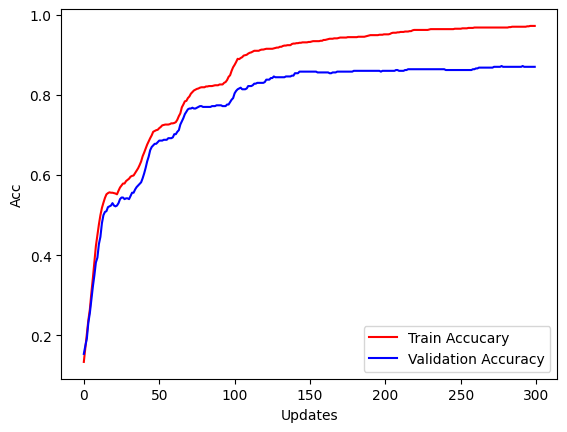

In [108]:
# we could have done this ourselves,
# but we should be aware of sklearn and its tools
from sklearn.metrics import accuracy_score


# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 300
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(x_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(targets_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

This achieves a fairly high accuracy of 0.87 compared to the original network and other networks. I conclude that a mixture of additional layers, different activation function and using Adam for optimization can increase the maximum achievable accuracy. However I am not going to delve deeper into it for now.  

I then proceed with trying out regularization 

### Advanced assignments - Regularization 

I start by adding weight decay to the original network. 

I first try with L2 regularization which can simply be implemented in the optimization function:

In [109]:
#Hyperparameters
num_classes = 10
num_l1 = 512
num_features = x_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden, num_output):
        super(Net, self).__init__()  
        # input layer
        self.W_1 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden, num_features)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden), 0))
        # hidden layer
        self.W_2 = Parameter(init.xavier_normal_(torch.Tensor(num_output, num_hidden)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_output), 0))
        # define activation function in constructor
        self.activation = torch.nn.ELU()

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        x = F.linear(x, self.W_2, self.b_2)
        x = F.softmax(x, dim=1)
        return x


net = Net(num_features, num_l1, num_classes)

optimizer = optim.SGD(net.parameters(), lr=0.01, weight_decay= 0.5) # added weight decay
criterion = nn.CrossEntropyLoss()

Epoch  1 : Train Loss 0.230371 , Train acc 0.103000, Valid acc 0.102000
Epoch 11 : Train Loss 0.229045 , Train acc 0.263000, Valid acc 0.230000
Epoch 21 : Train Loss 0.229357 , Train acc 0.347000, Valid acc 0.296000
Epoch 31 : Train Loss 0.229768 , Train acc 0.415000, Valid acc 0.366000
Epoch 41 : Train Loss 0.230019 , Train acc 0.466000, Valid acc 0.400000
Epoch 51 : Train Loss 0.230148 , Train acc 0.489000, Valid acc 0.432000
Epoch 61 : Train Loss 0.230208 , Train acc 0.455000, Valid acc 0.410000
Epoch 71 : Train Loss 0.230236 , Train acc 0.351000, Valid acc 0.324000
Epoch 81 : Train Loss 0.230248 , Train acc 0.242000, Valid acc 0.236000
Epoch 91 : Train Loss 0.230253 , Train acc 0.202000, Valid acc 0.202000
Epoch 101 : Train Loss 0.230255 , Train acc 0.146000, Valid acc 0.134000
Epoch 111 : Train Loss 0.230256 , Train acc 0.117000, Valid acc 0.120000
Epoch 121 : Train Loss 0.230256 , Train acc 0.117000, Valid acc 0.120000
Epoch 131 : Train Loss 0.230257 , Train acc 0.117000, Valid a

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

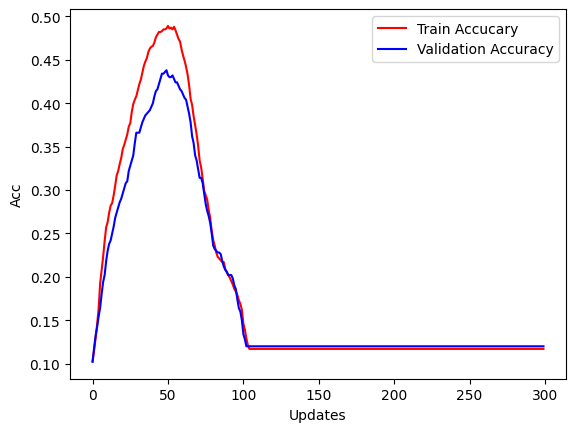

In [110]:
# we could have done this ourselves,
# but we should be aware of sklearn and its tools
from sklearn.metrics import accuracy_score


# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 300
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(x_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(targets_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

This regularization seems way to aggresive as it does not come close to converging

Try with 0.1 instead: 

In [115]:
#Hyperparameters
num_classes = 10
num_l1 = 512
num_features = x_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden, num_output):
        super(Net, self).__init__()  
        # input layer
        self.W_1 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden, num_features)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden), 0))
        # hidden layer
        self.W_2 = Parameter(init.xavier_normal_(torch.Tensor(num_output, num_hidden)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_output), 0))
        # define activation function in constructor
        self.activation = torch.nn.ELU()

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        x = F.linear(x, self.W_2, self.b_2)
        x = F.softmax(x, dim=1)
        return x


net = Net(num_features, num_l1, num_classes)

optimizer = optim.SGD(net.parameters(), lr=0.01, weight_decay= 0.1) # added weight decay
criterion = nn.CrossEntropyLoss()

Epoch  1 : Train Loss 0.230517 , Train acc 0.072000, Valid acc 0.058000
Epoch 11 : Train Loss 0.227708 , Train acc 0.276000, Valid acc 0.234000
Epoch 21 : Train Loss 0.224745 , Train acc 0.462000, Valid acc 0.388000
Epoch 31 : Train Loss 0.221748 , Train acc 0.522000, Valid acc 0.482000
Epoch 41 : Train Loss 0.219307 , Train acc 0.538000, Valid acc 0.506000
Epoch 51 : Train Loss 0.217640 , Train acc 0.546000, Valid acc 0.524000
Epoch 61 : Train Loss 0.216587 , Train acc 0.550000, Valid acc 0.536000
Epoch 71 : Train Loss 0.215983 , Train acc 0.550000, Valid acc 0.540000
Epoch 81 : Train Loss 0.215697 , Train acc 0.551000, Valid acc 0.538000
Epoch 91 : Train Loss 0.215630 , Train acc 0.547000, Valid acc 0.528000
Epoch 101 : Train Loss 0.215711 , Train acc 0.544000, Valid acc 0.524000
Epoch 111 : Train Loss 0.215886 , Train acc 0.540000, Valid acc 0.514000
Epoch 121 : Train Loss 0.216118 , Train acc 0.536000, Valid acc 0.498000
Epoch 131 : Train Loss 0.216382 , Train acc 0.524000, Valid a

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

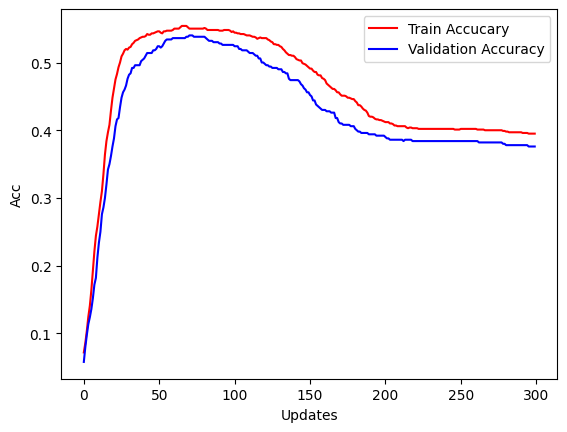

In [116]:
# we could have done this ourselves,
# but we should be aware of sklearn and its tools
from sklearn.metrics import accuracy_score


# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 300
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(x_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(targets_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

Still seems to aggresive. I try 1e-4

In [122]:
#Hyperparameters
num_classes = 10
num_l1 = 512
num_features = x_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden, num_output):
        super(Net, self).__init__()  
        # input layer
        self.W_1 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden, num_features)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden), 0))
        # hidden layer
        self.W_2 = Parameter(init.xavier_normal_(torch.Tensor(num_output, num_hidden)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_output), 0))
        # define activation function in constructor
        self.activation = torch.nn.ELU()

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        x = F.linear(x, self.W_2, self.b_2)
        x = F.softmax(x, dim=1)
        return x


net = Net(num_features, num_l1, num_classes)

optimizer = optim.Adam(net.parameters(), lr=1e-4, weight_decay= 1e-3) # added weight decay
criterion = nn.CrossEntropyLoss()

Epoch  1 : Train Loss 0.228226 , Train acc 0.284000, Valid acc 0.252000
Epoch 11 : Train Loss 0.180241 , Train acc 0.781000, Valid acc 0.744000
Epoch 21 : Train Loss 0.167255 , Train acc 0.861000, Valid acc 0.820000
Epoch 31 : Train Loss 0.161714 , Train acc 0.904000, Valid acc 0.822000
Epoch 41 : Train Loss 0.158333 , Train acc 0.930000, Valid acc 0.842000
Epoch 51 : Train Loss 0.156112 , Train acc 0.947000, Valid acc 0.850000
Epoch 61 : Train Loss 0.154629 , Train acc 0.957000, Valid acc 0.844000
Epoch 71 : Train Loss 0.153561 , Train acc 0.963000, Valid acc 0.852000
Epoch 81 : Train Loss 0.152771 , Train acc 0.964000, Valid acc 0.856000
Epoch 91 : Train Loss 0.152174 , Train acc 0.967000, Valid acc 0.858000
Epoch 101 : Train Loss 0.151700 , Train acc 0.969000, Valid acc 0.856000
Epoch 111 : Train Loss 0.151333 , Train acc 0.973000, Valid acc 0.854000
Epoch 121 : Train Loss 0.151052 , Train acc 0.973000, Valid acc 0.852000
Epoch 131 : Train Loss 0.150827 , Train acc 0.974000, Valid a

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

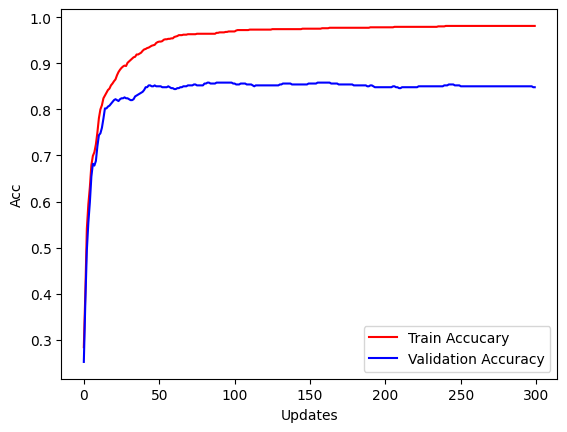

In [123]:
# we could have done this ourselves,
# but we should be aware of sklearn and its tools
from sklearn.metrics import accuracy_score


# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 300
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(x_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(targets_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')